In [1]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
style.use('fast')
from datetime import datetime
from io import StringIO
import re
import numpy as np
from datetime import datetime
import os

sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22


# Packages installed in official and community images: 13march -> 27march
################################################################################################################
################################################################################################################


In [2]:
# Starts here #########################
community_packages=pd.read_csv('../docker/csv/packages_from_community_images.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
community_packages['debian']=community_packages['release'].apply(lambda x:
                                                               'jessie' if x.startswith('8')
                                                               else 'stretch' if x.startswith('9')
                                                               else 'wheezy' if x.startswith('7')
                                                               else 'squeeze' if x.startswith('6')
                                                               else 'buster' if x.startswith('buster')
                                                                else x)
#community_packages['date']='27-03-2018'
community_packages['package']=community_packages['package'].apply(lambda x: x.split(':')[0])
community_packages=community_packages.query('debian!="wheezy" and debian!="squeeze"')

community_packages.drop_duplicates(inplace=True)
len(community_packages)

1393966

In [3]:
official_packages=pd.read_csv('../docker/csv/packages_from_official_images.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
official_packages['debian']=official_packages['release'].apply(lambda x:
                                                               'jessie' if x.startswith('8')
                                                               else 'stretch' if x.startswith('9')
                                                               else 'wheezy' if x.startswith('7')
                                                               else 'squeeze' if x.startswith('6')
                                                               else 'buster' if x.startswith('buster')
                                                                else x)
#official_packages['date']='27-03-2018'
official_packages['package']=official_packages['package'].apply(lambda x: x.split(':')[0])
official_packages=official_packages.query('debian!="wheezy" and debian!="squeeze"')

official_packages.drop_duplicates(inplace=True)

len(official_packages)

566622

In [5]:
#################### here we add dates about when they were created ################
# this cell is to get dates
official_layers=pd.read_csv('../docker/csv/layers_official_23MARCH.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)

community_layers=pd.read_csv('../docker/csv/layers_community_march_12k.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
image_date=pd.read_csv('../docker/csv/images_when_created_both_April.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)

created_date=pd.concat([official_layers,community_layers,community_layers])



created_date['created']=created_date['created'].apply(lambda x: str(x).split('T')[0])
created_date=created_date.groupby(['slug','tag','created']).count().reset_index()

created_date['name']=created_date['slug']+':'+created_date['tag']
created_date.drop(['slug','tag','level','layer'], axis=1, inplace=True)
created_date=pd.concat([image_date,created_date])
created_date.sort_values('created', ascending=False, inplace=True)
created_date=created_date.groupby('name').first().reset_index()
####################################################################################


official_packages=(official_packages.set_index('name').
    merge(created_date.
          set_index('name'),
          left_index=True,
          right_index=True,
          how='outer')
   ).reset_index().dropna()


community_packages=(community_packages.set_index('name').
    merge(created_date.
          set_index('name'),
          left_index=True,
          right_index=True,
          how='outer')
   ).reset_index().dropna()

print('Official containers installed package versions', len(official_packages))
print('Community containers installed package versions', len(community_packages))

Official containers installed package versions 566622
Community containers installed package versions 1393966


In [6]:
# How many containers
official_packages['type']="Official"
community_packages['type']="Community"

df_tmp=pd.concat([official_packages,community_packages])
df_tmp.groupby(['name','debian','type']).count().groupby(['type','debian']).count()

package  version  release  created
type      debian                                     
Community buster        86       86       86       86
          jessie      3593     3593     3593     3593
          stretch     1248     1248     1248     1248
Official  buster       150      150      150      150
          jessie      1683     1683     1683     1683
          stretch      620      620      620      620

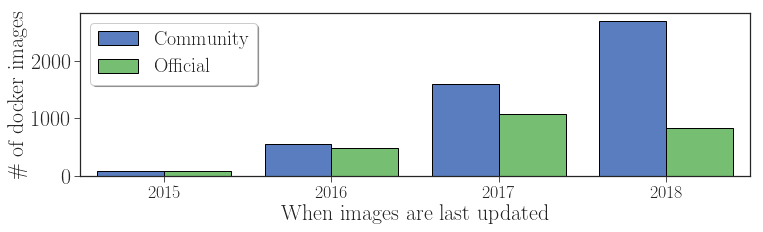

In [7]:
# date of creation/update
official_packages['type']="Official"
community_packages['type']="Community"

df_tmp=pd.concat([official_packages,community_packages])
df_tmp['year']=df_tmp['created'].apply(lambda x: x.split('-')[0])
#df_tmp.query('year>"2015"', inplace=True)
df_tmp=df_tmp.groupby(['name','debian','type','year']).count().groupby(['type','year']).count().reset_index()
#len(df_tmp.groupby(['name']).count())

ax = sns.barplot(y="package", x='year', hue='type', data=df_tmp, palette="muted", linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("When images are last updated")
ax.set_ylabel('\# of docker images')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper left',  fontsize=20, fancybox=True, shadow=True)

In [218]:
official_packages.query('name=="debian:jessie"')

,name,package,version,release,debian,created,type
30696,debian:jessie,acl,2.2.52-2,8.10,jessie,2018-03-13,Official
30697,debian:jessie,adduser,3.113+nmu3,8.10,jessie,2018-03-13,Official
30698,debian:jessie,apt,1.0.9.8.4,8.10,jessie,2018-03-13,Official
30699,debian:jessie,base-files,8+deb8u10,8.10,jessie,2018-03-13,Official
30700,debian:jessie,base-passwd,3.5.37,8.10,jessie,2018-03-13,Official
30701,debian:jessie,bash,4.3-11+deb8u1,8.10,jessie,2018-03-13,Official
30702,debian:jessie,bsdutils,1:2.25.2-6,8.10,jessie,2018-03-13,Official
30703,debian:jessie,coreutils,8.23-4,8.10,jessie,2018-03-13,Official
30704,debian:jessie,dash,0.5.7-4+b1,8.10,jessie,2018-03-13,Official
30705,debian:jessie,debconf,1.5.56+deb8u1,8.10,jessie,2018-03-13,Official


In [193]:
all: 7380
2018: 3526
2017->2018: 6194
2016->2018: 7222

3526

################################################################################################################
################################################################################################################
# Here are debian packages until 18March
################################################################################################################
################################################################################################################


In [95]:
for index, file in enumerate(os.listdir('../docker/debian_packages_18March/')):
    if index ==0:
        debian_packages=pd.read_csv('../docker/debian_packages_18March/'+file, sep=';', dtype=object, index_col=None,  error_bad_lines=False)
    else:
        df=pd.read_csv('../docker/debian_packages_18March/'+file, sep=';', dtype=object, index_col=None,  error_bad_lines=False)
        debian_packages=pd.concat([debian_packages,df])
len(debian_packages)

690148

In [96]:
debian_packages=debian_packages.drop("priority", axis=1)
#debian_packages=debian_packages.loc[:,['package','version','source']]
debian_packages.drop_duplicates(inplace=True)
######## Now here we consider only the first date when the package version was seen
debian_packages=(debian_packages.
                 sort_values('date', ascending=True).
                 groupby(['package','version']).
                 first().
                 reset_index())

debian_packages['source_version']=debian_packages['version']+'|'+debian_packages['source']
debian_packages['source_version']=debian_packages['source_version'].apply(lambda x:
                                                                          x.split('|')[1].split(')')[0].split('(')[1] if '(' in x.split('|')[1]
                                                                          else x.split('|')[0])
debian_packages['source']=debian_packages['source'].apply(lambda x: x.split('(')[0])

len(debian_packages)

587746

In [98]:
#debian_packages.to_csv('datasets/debian_packages_18March.csv', index=False, sep=";")

In [35]:
# len(debian_packages) == len(debian_packages.loc[:,['package','version']].drop_duplicates())

In [11]:
# get source name and version of packages found in OFFICIAL images
df=official_packages.set_index(['package','version']).merge(
    debian_packages.set_index(['package','version']),
    left_index=True, 
    right_index=True, 
    how='outer')
official_sources=df.reset_index().dropna()
'analyzed packages:',len(df.dropna())/len(official_packages)

('analyzed packages:', 0.9872719379056938)

In [12]:
# get source name and version of packages found in COMMUNITY images
df=community_packages.set_index(['package','version']).merge(
    debian_packages.set_index(['package','version']),
    left_index=True, 
    right_index=True, 
    how='outer')
community_sources=df.reset_index().dropna()
'analyzed packages:',len(df.dropna())/len(community_packages)

('analyzed packages:', 0.9870728554354984)

In [223]:
# missing ones
len(df[df['source_version'].apply(pd.isna)].reset_index().loc[:,
                                                          ['package','version']
                                                         ].drop_duplicates())
# len(community_packages.groupby(['package','version']).count())

6419

In [13]:
# Just change the name of the debian repository to 'jessie, stretch, buster'
official_sources['release_snapshot']=official_sources['release_y'].apply(lambda x:
                                                                        'jessie' if 'jessie' in x
                                                                        else 'stretch' if 'stretch' in x
                                                                        else x)

official_sources['inSecurity']=official_sources['release_y'].apply(lambda x:
                                                                        'True' if 'security' in x
                                                                        else 'False')
official_sources['release_repo']=official_sources['release_y']
official_sources.drop(['release_x','release_y'], axis=1, inplace=True)


community_sources['release_snapshot']=community_sources['release_y'].apply(lambda x:
                                                                        'jessie' if 'jessie' in x
                                                                        else 'stretch' if 'stretch' in x
                                                                        else x)

community_sources['inSecurity']=community_sources['release_y'].apply(lambda x:
                                                                        'True' if 'security' in x
                                                                        else 'False')

community_sources['release_repo']=community_sources['release_y']
community_sources.drop(['release_x','release_y'], axis=1, inplace=True)


Text(1.05,1.05,'Where first seen ')

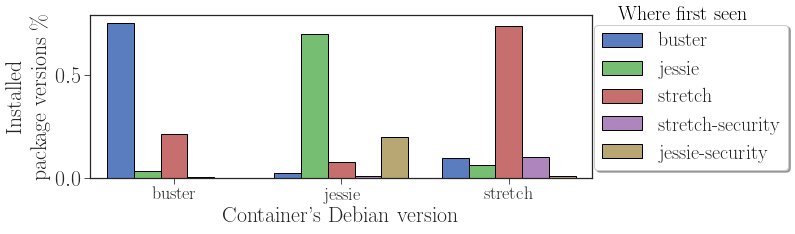

In [14]:
# Plot where UNIQUE packages were first seen 
first_seen_used=(community_sources.
                 query('created>"2018"').
                 groupby(['debian','release_repo','package','version']).
                 count())
first_seen_used=first_seen_used.groupby(['debian','release_repo']).count()
first_seen_used.reset_index(inplace=True)
first_seen_used['usage']=first_seen_used[['debian','name']].apply(lambda x:
                                                                    x['name']/max(first_seen_used.query('debian=="buster"')['name'].cumsum()) if x['debian']=='buster'
                                                                    else x['name']/max(first_seen_used.query('debian=="stretch"')['name'].cumsum()) if x['debian']=='stretch'
                                                                    else x['name']/max(first_seen_used.query('debian=="jessie"')['name'].cumsum()),
                                                                    axis=1)
ax = sns.barplot(x="debian", y="usage", hue="release_repo", data=first_seen_used, palette="muted", linewidth=1)
ax.figure.set_size_inches(9,3)
ax.set_xlabel("Container's Debian version")
ax.set_ylabel('Installed \n package versions \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1.41, 1), fontsize=20, fancybox=True, shadow=True)
ax.text(1.05, 1.05, 'Where first seen ', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

In [29]:
###### when the last versions were created  ( ALL OF THEM)
df=debian_packages.sort_values('date', ascending=True) # sort the by date
df.rename(columns = {'release':'release_snapshot'}, inplace=True) # change the name of the column
df['version_order'] = df.groupby(['package','release_snapshot']).cumcount()+1 # order versions by number
df= df.groupby(['source','release_snapshot']).last() # take the last order

df['year']=df['date'].apply(lambda x: x[0:4])

(df.
 groupby(['source','year','release_snapshot']).
 count().
 groupby(['release_snapshot','year']).
 count())

package  version   date  source_version  version_order
release_snapshot year                                                        
buster           2017    10787    10787  10787           10787          10787
                 2018     6432     6432   6432            6432           6432
jessie           2013    10849    10849  10849           10849          10849
                 2014    13514    13514  13514           13514          13514
                 2015      622      622    622             622            622
                 2016      185      185    185             185            185
                 2017      218      218    218             218            218
jessie-security  2015       49       49     49              49             49
                 2016      114      114    114             114            114
                 2017      170      170    170             170            170
                 2018       46       46     46              46             46
stretch          2015     5444     5444   5444            5444           5444
                 2016    14821    14821  14821           14821          14821
                 2017     7609     7609   7609            7609           7609
                 2018       84       84     84              84             84
stretch-security 2017      105      105    105             105            105
                 2018       59       59     59              59             59

################################################################################################################
################################################################################################################
# Let's see if packages are outdated
################################################################################################################
################################################################################################################

In [15]:
# Unique packages that should be looked for bugs and vulnerabilities
uniq_packages=pd.concat([
    official_sources.loc[:,['package','version','source','source_version']].drop_duplicates(),
    community_sources.loc[:,['package','version','source','source_version']].drop_duplicates()
])
uniq_packages.drop_duplicates(inplace=True)
len(uniq_packages)

16792

In [104]:

# Prepare the dataframe
if True:
    debian_packages_order=debian_packages.sort_values('date', ascending=True) # sort the by date
    debian_packages_order.rename(columns = {'release':'release_snapshot'}, inplace=True) # change the name of the column
    debian_packages_order['release_snapshot']=debian_packages_order['release_snapshot'].apply(lambda x:
                                                                            'jessie' if 'jessie' in x
                                                                            else 'stretch' if 'stretch' in x
                                                                            else x)
    debian_packages_order['version_order'] = debian_packages_order.groupby(['package','release_snapshot']).cumcount()+1 # order versions by number
if True:

    df_2= debian_packages_order.groupby(['package','release_snapshot']).last() # take the last order
    df_2= df_2.loc[:,['version_order','version']] 
    df_2.rename(columns = {'version_order':'last_order','version':'latest'}, inplace=True) # change the name of the column

    # Merge here
    debian_packages_order=debian_packages_order.set_index(['package','release_snapshot']).merge(
        df_2,
        left_index=True, 
        right_index=True, 
        how='outer').reset_index()

In [105]:
debian_packages_order.to_csv('datasets/debian_packages_18March.csv', index=False, sep=";")

In [107]:
debian_packages_order.query('release_snapshot=="stretch-security"')

,package,release_snapshot,version,date,source,source_version,version_order,last_order,latest


In [100]:
# To verify if it is correct
#debian_packages_order['version_order'] = debian_packages_order.groupby(['package','release_snapshot']).cumcount()+1 # order versions by number
debian_packages_order.query('package=="tomcat8"').query('release_snapshot=="jessie"')

,package,release_snapshot,version,date,source,source_version,version_order,last_order
558689,tomcat8,jessie,8.0.5-1,20140508,tomcat8,8.0.5-1,1,16
558690,tomcat8,jessie,8.0.8-1,20140529,tomcat8,8.0.8-1,2,16
558691,tomcat8,jessie,8.0.9-1,20140630,tomcat8,8.0.9-1,3,16
558692,tomcat8,jessie,8.0.12-1,20140923,tomcat8,8.0.12-1,4,16
558693,tomcat8,jessie,8.0.14-1,20141005,tomcat8,8.0.14-1,5,16
558694,tomcat8,jessie,8.0.14-1+deb8u1,20151219,tomcat8,8.0.14-1+deb8u1,6,16
558695,tomcat8,jessie,8.0.14-1+deb8u2,20160630,tomcat8,8.0.14-1+deb8u2,7,16
558696,tomcat8,jessie,8.0.14-1+deb8u3,20160916,tomcat8,8.0.14-1+deb8u3,8,16
558697,tomcat8,jessie,8.0.14-1+deb8u4,20161122,tomcat8,8.0.14-1+deb8u4,9,16
558698,tomcat8,jessie,8.0.14-1+deb8u5,20161219,tomcat8,8.0.14-1+deb8u5,10,16


In [18]:
# Create the dataframe with outdates
df=debian_packages_order.loc[:,['package','version','version_order','last_order']]

# Official
outdate_official=official_sources.set_index(['package','version']).merge(
    df.set_index(['package','version']),
    left_index=True, 
    right_index=True, 
    how='outer').dropna().reset_index()

outdate_official['outdate']=outdate_official['last_order']-outdate_official['version_order']
outdate_official['isOutdate']=outdate_official['outdate'].apply(lambda x: 'Out-of-date' if x!=0
                                                                 else 'Up-to-date')
# Community
outdate_community=community_sources.set_index(['package','version']).merge(
    df.set_index(['package','version']),
    left_index=True, 
    right_index=True, 
    how='outer').dropna().reset_index()

outdate_community['outdate']=outdate_community['last_order']-outdate_community['version_order']
outdate_community['isOutdate']=outdate_community['outdate'].apply(lambda x: 'Out-of-date' if x!=0
                                                                 else 'Up-to-date')
print('Outdated Community packages:', len(outdate_community))
print('Outdated Official packages:', len(outdate_official))

Outdated Community packages: 1375946
Outdated Official packages: 559410


In [310]:
########### SKIP, this is just to show the next graph but only for one type
if True:
    dff=outdate_official.groupby(['debian']).count().loc[:,['package']].merge(
        outdate_official.groupby(['isOutdate','debian']).count().loc[:,['version']].reset_index().set_index('debian'),
        left_index=True, 
        right_index=True, 
        how='outer').reset_index()
    dff['installed']=dff['version']*100/dff['package']

    order=['jessie','stretch','buster']

    ax = sns.barplot(x="debian", y="installed", hue="isOutdate", data=dff, order=order, palette="muted", linewidth=1)
    ax.figure.set_size_inches(12,3)
    ax.set_xlabel("Container's Debian version")
    ax.set_ylabel('Installed \n package versions \%')
    for patch in ax.patches:
        patch.set_edgecolor('black')
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
    ax.text(0.18, 1.15, 'Official Images', transform=ax.transAxes, fontsize=20,
            verticalalignment='top', color='black')

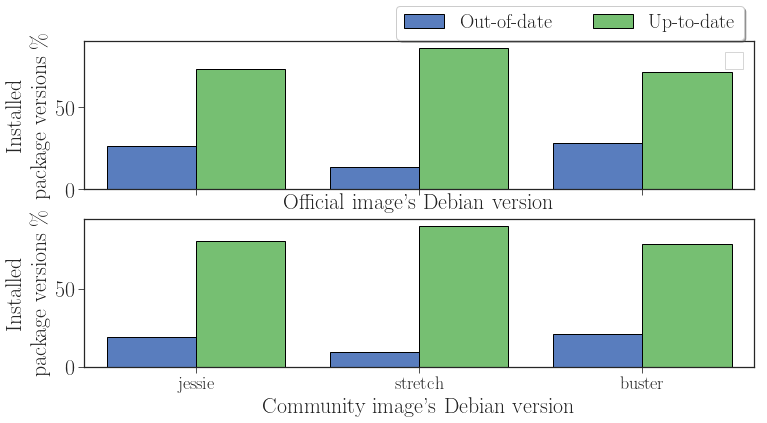

In [318]:
dff=pd.concat([outdate_official,outdate_community])
dff=(dff.
     groupby(['debian','type']).
     count().
     loc[:,['package']].
     merge(
         dff.
         groupby(['isOutdate','type','debian']).
         count().
         loc[:,['version']].
         reset_index().
         set_index(['debian','type']),
         left_index=True,
         right_index=True, 
         how='outer').reset_index())
dff['installed']=dff['version']*100/dff['package']

fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)

order=['jessie','stretch','buster']

for index, type in enumerate(['Official', 'Community']):
    data=dff.query('type=="'+type+'"')
    ax = sns.barplot(x="debian", y="installed", hue="isOutdate",
                     data=data, palette="muted", order=order, linewidth=1,
                    ax=axes[index])
    ax.figure.set_size_inches(12,6)
    ax.set_ylabel('Installed \n package versions \%')
    for patch in ax.patches:
        patch.set_edgecolor('black')
    ax.legend('',fancybox=False, shadow=False)
    ax.set_xlabel(type+" image's Debian version")
ax.legend(loc='upper right', bbox_to_anchor=(1, 2.5), ncol=3, fontsize=20, fancybox=True, shadow=True)



In [15]:
df=outdate_community.groupby(['package','isOutdate']).count().groupby(['package']).count()
df.groupby('version').count()
# Check how packages are always up to date or always not updated

,name,debian,date_x,date_y,source,source_version,release_snapshot,version_order,last_order,outdate
version,,,,,,,,,,
1,6472,6472,6472,6472,6472,6472,6472,6472,6472,6472
2,1427,1427,1427,1427,1427,1427,1427,1427,1427,1427


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(0, 10)

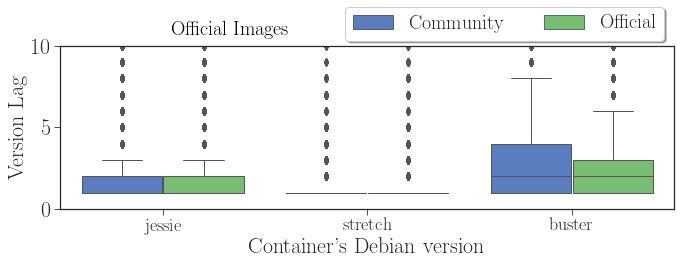

In [19]:
#### For those who are outdated! what is the technical lag
dff1=outdate_official.query('outdate!=0')
dff1['type']='Official'

dff2=outdate_community.query('outdate!=0')
dff2['type']='Community'
dff=pd.concat([dff2,dff1])

order=['jessie','stretch','buster']

ax = sns.boxplot(x="debian", y="outdate", data=dff, hue='type', palette="muted", order=order, linewidth=1)
ax.figure.set_size_inches(11,3)
ax.set_xlabel("Container's Debian version")
ax.set_ylabel('Version Lag')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.18, 1.15, 'Official Images', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')
ax.set_ylim(0,10)

################################################################################################################
################ It seems that packages are up to date ################
################ Let's check when they were first seen ################
################################################################################################################


In [20]:
print('Official outdated package', len(outdate_official.query('outdate!=0'))*100/len(outdate_official),'%')
print('Community outdated package', len(outdate_community.query('outdate!=0'))*100/len(outdate_community),'%')

Official outdated package 22.795266441429362 %
Community outdated package 16.942161974379808 %


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


(734989.0, 736754.0)

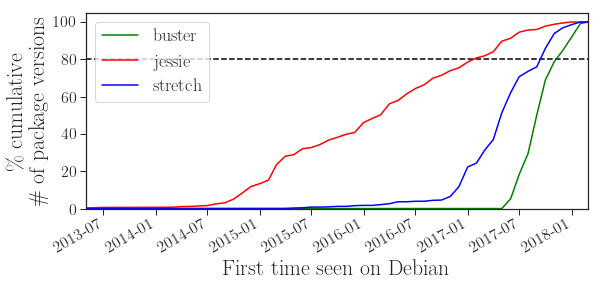

In [106]:
### When package versions that are NOT outdated were first seen

if False: ## Considering both official and community
    dff1=outdate_official.query('outdate==0')
    dff1['type']='Official'

    dff2=outdate_community.query('outdate==0')
    dff2['type']='Community'
    df=pd.concat([dff2,dff1])
else: # Only community or Official
    df=outdate_community.query('outdate!=0')

df['date']=df['date_y'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-01')
df=(df.
 groupby(['package','version','date','release_snapshot']).
 count().
 reset_index().
 groupby(['date','release_snapshot']).
 count().
 loc[:,['package']].
 reset_index())

df=(df.
    pivot(index='date', columns='release_snapshot', values='package').
    fillna(0).
    reset_index().
    sort_values('date', ascending=True))
df['date']=df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df.set_index('date', inplace=True)
for x in df:
    df[x]=df[x].cumsum()
    max=df[x].values.max()
    df[x]=df[x]*100/max
    #df.drop([x], axis=1, inplace=True)


ax=df.plot( color=['green','red','blue'])#, ax=axes[int(i/2)][j], label=type)    
ax.hlines(80, pd.to_datetime('2013-05-01'), pd.to_datetime('2018-03-01'), colors='black', linestyles='dashed', alpha=1)

ax.set_ylim(0,)
ax.set_ylabel('\% cumulative \n \# of package versions')
ax.set_xlabel('First time seen on Debian')
ax.figure.set_size_inches(9,4)
plt.tick_params(axis='both', which='major', labelsize=16, width=1)
plt.legend(loc='upper left', prop={'size': 18})

ax.set_xlim(pd.to_datetime('2013-05-01'), pd.to_datetime('2018-03-01'))

In [21]:
debian_packages_order.query('package=="tomcat8"').query('release_snapshot=="jessie"')

,package,release_snapshot,version,date,source,source_version,version_order,last_order
558689,tomcat8,jessie,8.0.5-1,20140508,tomcat8,8.0.5-1,1,16
558690,tomcat8,jessie,8.0.8-1,20140529,tomcat8,8.0.8-1,2,16
558691,tomcat8,jessie,8.0.9-1,20140630,tomcat8,8.0.9-1,3,16
558692,tomcat8,jessie,8.0.12-1,20140923,tomcat8,8.0.12-1,4,16
558693,tomcat8,jessie,8.0.14-1,20141005,tomcat8,8.0.14-1,5,16
558694,tomcat8,jessie,8.0.14-1+deb8u1,20151219,tomcat8,8.0.14-1+deb8u1,6,16
558695,tomcat8,jessie,8.0.14-1+deb8u2,20160630,tomcat8,8.0.14-1+deb8u2,7,16
558696,tomcat8,jessie,8.0.14-1+deb8u3,20160916,tomcat8,8.0.14-1+deb8u3,8,16
558697,tomcat8,jessie,8.0.14-1+deb8u4,20161122,tomcat8,8.0.14-1+deb8u4,9,16
558698,tomcat8,jessie,8.0.14-1+deb8u5,20161219,tomcat8,8.0.14-1+deb8u5,10,16


################################################################################################################
################################################################################################################
# Let's check vulnerabilities
If yoou don't want to analyze only vulnerabilities without knowing the type of container, you can skip this part
################################################################################################################
################################################################################################################


In [167]:

# Use only once: Skip
import json as js
import codecs
vulnerabilities=js.load(codecs.open('../docker/csv/security-debian_1April.json', 'r', 'utf-8'))
vulnerabilities['apache2']['CVE-2008-0456']['releases']['jessie']

{'repositories': {'jessie': '2.4.10-10+deb8u11',
  'jessie-security': '2.4.10-10+deb8u11'},
 'status': 'open',
 'urgency': 'unimportant'}

In [162]:
import json as js
import codecs

def parse_json_vuls():
    vulnerabilities=js.load(codecs.open('../docker/csv/security-debian_1April.json', 'r', 'utf-8'))
    return vulnerabilities

def dates_release_debian():
    debian_p=debian_packages
    df_packages=(debian_p.
                 sort_values('date', ascending=True).
                 groupby(['source','source_version','release']).
                 first().
                 drop(['package','version'], axis=1)
                )

    dict_date=df_packages.to_dict() ### dict of source version dates

    df_packages_release=(debian_p.
                         sort_values('date', ascending=True).
                         groupby(['source','source_version']).
                         first().
                         drop(['package','version','date'], axis=1)
                        )

    dict_release=df_packages_release.to_dict() # dict of releases
    return dict_date, dict_release

def unique_installed_packages(tracked_packages):
    df=(tracked_packages. ######## We create a DF with source packages found in Docker containers
        groupby(['source','source_version']).
        count().
        drop(['package','version'], axis=1).
        reset_index()
       ) ######## only source versions and distinct.
    
    return df

def final_vuls(tracked_packages):
    
    vulnerabilities=parse_json_vuls()
    
    dict_date, dict_release = dates_release_debian()
    
    sorted_ip=unique_installed_packages(tracked_packages)
    
    
    fcsv=open('../docker/csv/docker_vulnerabilities.csv','w')
    fcsv.write('source;source_version;urgency;status;fixed_version;debianbug;release;cve\n')

    for index, raw in enumerate(sorted_ip.iterrows()): ######## we iterate over the sources (docker)
        source=raw[1]['source']
        source_version=raw[1]['source_version']
        release=dict_release['release'][(source, source_version)]
        date_source=dict_date['date'][(source, source_version,release)]
        try:
            vuls=vulnerabilities[source] ###### check if the source has any vulnerabilities
        except:
            continue
        for cve in vuls:  ###### for each vulnerability
            if not cve.startswith('CVE'):
                continue
            #if cve.split('-')[1] > date_source[0:4]:
            #    continue
            v=vulnerabilities[source][cve]
            try:
                status=v['releases'][release]['status']  ###### check only the release of source
                urgency=v['releases'][release]['urgency'] ###### check only the release of source

                try:
                    debianbug=str(v['debianbug'])
                except:
                    debianbug="undefined"

                if status == "open" or status=="undetermined": ###### if the vulnerability is still OPEN
                    fixed="undefined"
                    fcsv.write(source+';'+source_version+';'+urgency+';'+status+';'+fixed+';'+debianbug+';'+release+';'+cve+'\n')
                else: ###### if the vulnerability is RESOLVED
                    try:
                        fixed=v['releases'][release]["fixed_version"]
                    except:
                        continue
                    try:
                        date_fixed=dict_date['date'][(source, fixed,release)]
                        if date_source<date_fixed: #### Compare between the used source and fixed one (dates comparison)
                            fcsv.write(source+';'+source_version+';'+urgency+';'+status+';'+fixed+';'+debianbug+';'+release+';'+cve+'\n')
                    except:
                        if compare_versions(source_version,fixed):
                            fcsv.write(source+';'+source_version+';'+urgency+';'+status+';'+fixed+';'+debianbug+';'+release+';'+cve+'\n')
                            
            except:
                pass
    fcsv.close()
    
def get_vuls(tracked_packages, bol):
    if bol:
        final_vuls(tracked_packages)
    
    docker_vulnerabilities=pd.read_csv('../docker/csv/docker_vulnerabilities.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
    docker_vulnerabilities.drop_duplicates(inplace=True)
    
    return docker_vulnerabilities

In [163]:

def calculate_version(source_version,fixed,operator):    
    try:
        f=fixed[0]
        n=source_version[0]
    except:
        if operator!='~':
            if len(source_version)==0:
                return True
            else:
                return False
        else:
            if len(source_version)==0:
                return True
            else:
                return False
    
    if n == f:
        return calculate_version(source_version[1:],fixed[1:],operator)
    else:
        for op in [':','-','~','+']:
            if op in n or op in f:
                if op==":":
                    if ':' in f and ':' not in n :
                        if int(f.split(':')[0])>1:
                            return True
                        else:
                            return calculate_version(n,f.split(':')[1],op)
                            
                    elif ':' in n and ':' not in f :
                        if int(n.split(':')[0])>1:
                            return False
                        else:
                            return calculate_version(n.split(':')[1],f,op)
                    else:
                        if int(n.split(':')[0])<int(f.split(':')[0]):
                            return True
                        elif int(n.split(':')[0])>int(f.split(':')[0]):
                            return False
                        else:
                            try:
                                if int(n.split(':')[1])<int(f.split(':')[1]):
                                    return True
                                elif int(n.split(':')[1])>int(f.split(':')[1]):
                                    return False
                            except:
                                return calculate_version(n.split(':')[1:],f.split(':')[1:], ':')
                else:
                    return calculate_version(n.split(op),f.split(op),op)
                
        try:
            if int(n)<int(f):
                return True
            else:
                return False
        except:
            if n<f:
                return True
            else:
                return False

def compare_versions(source_version,fixed):
    if fixed != source_version:
        source_version=source_version.split('.')
        fixed=fixed.split('.')
        return calculate_version(source_version,fixed,'.')
    else:
        return True

In [143]:
def merge_vuls(tracked_packages):
    vuls=get_vuls(tracked_packages)            ### GET VULNERABILITIES
    # Here we merge vulnerabilities with community outdated packages
    docker_vuls=(
        tracked_packages.
        set_index(['source','source_version']).
        merge(vuls.
              set_index(['source','source_version']),
              left_index=True, 
              right_index=True, 
              how='outer').dropna().reset_index().drop_duplicates()
    )
    return docker_vuls

In [164]:
# Use only once: Skip
# Identify vulnerabilities
#######################################################################################################
######################## This part is to track packages dates and releases ###########################

docker_vulnerabilities=get_vuls(uniq_packages,True)

In [159]:
# Vulnerabilities
docker_vulnerabilities=pd.read_csv('../docker/csv/docker_vulnerabilities.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
docker_vulnerabilities.drop_duplicates(inplace=True)
len(docker_vulnerabilities)

28349

In [166]:
# do not remove
docker_vulnerabilities.groupby('status').count()
#docker_vulnerabilities.query('source_version!=fixed_version').query('status=="open"').sort_values('fixed_version')
# check with https://anchore.io/image/dockerhub/library%2Fbackdrop%3Alatest
#docker_vulnerabilities.query('source_version=="2.4.10-10+deb8u11"').query('status=="open"') # check with

,source,source_version,urgency,fixed_version,debianbug,release,cve
status,,,,,,,
open,12261,12261,12261,12261,12261,12261,12261
resolved,15696,15696,15696,15696,15696,15696,15696
undetermined,392,392,392,392,392,392,392


Text(0.18,1.15,'Status:')

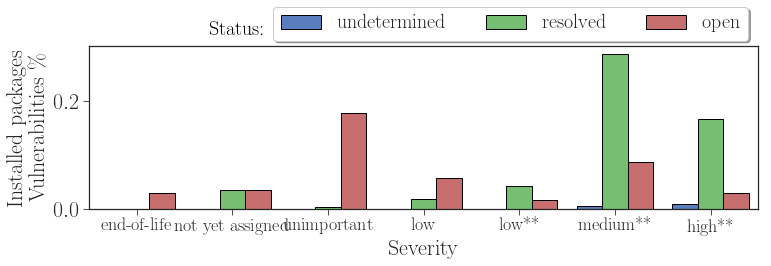

In [293]:
#docker_vulnerabilities['urgency']=docker_vulnerabilities['urgency'].apply(lambda x: 'other' if x.startswith('u')
#                                    else 'other' if x.startswith('n')
#                                    else x)
vuls=docker_vulnerabilities.groupby(['urgency','status']).count().reset_index()
vuls['source']=vuls['source']/len(docker_vulnerabilities)
vuls=vuls.sort_values('urgency', ascending=False)

ax = sns.barplot(x="urgency", 
                 y="source", 
                 hue="status", 
                 order=['end-of-life', 'not yet assigned','unimportant', 'low', 'low**', 'medium**', 'high**'],
                 data=vuls, 
                 palette="muted", 
                 linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Severity")
ax.set_ylabel('Installed packages \n Vulnerabilities \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.18, 1.15, 'Status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

In [117]:
docker_vulnerabilities.groupby(['status']).count()

,source,source_version,urgency,fixed_version,debianbug,release,cve
status,,,,,,,
open,12261,12261,12261,12261,12261,12261,12261
resolved,16045,16045,16045,16045,16045,16045,16045
undetermined,392,392,392,392,392,392,392


################################################################################################################
################################################################################################################
# Considering all installed package versions and their vulnerabilities
################################################################################################################
################################################################################################################

In [118]:
docker_vulnerabilities=pd.read_csv('../docker/csv/docker_vulnerabilities.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
docker_vulnerabilities.drop_duplicates(inplace=True)
len(docker_vulnerabilities)

28698

In [920]:
if False:
######################################## FORGET THIS: SKIP #######################################
    df=debian_packages_order.loc[:,['package','version','version_order','last_order', 'date', 'release_snapshot']]

    # Unique packages with outdated dataframe
    uniq_packages_outdated=uniq_packages.set_index(['package','version']).merge(
        df.set_index(['package','version']),
        left_index=True, 
        right_index=True, 
        how='outer').dropna().reset_index()

    uniq_packages_outdated['outdate']=uniq_packages_outdated['last_order']-uniq_packages_outdated['version_order']
    uniq_packages_outdated['isOutdate']=uniq_packages_outdated['outdate'].apply(lambda x: 'Out-of-date' if x!=0
                                                                     else 'Up-to-date')
    len(uniq_packages_outdated)
####################################################################################################

In [119]:
# Here we merge vulnerabilities with community outdated packages
lag_vul_community=(
    outdate_community.
    set_index(['source','source_version']).
    merge(docker_vulnerabilities.
          set_index(['source','source_version']),
          left_index=True, 
          right_index=True, 
          how='outer').dropna().reset_index().drop_duplicates()
)
lag_vul_community['type']='Community'
len(lag_vul_community)

7352214

In [120]:
# Here we merge vulnerabilities with official outdated packages
lag_vul_official=(
    outdate_official.
    set_index(['source','source_version']).
    merge(docker_vulnerabilities.
          set_index(['source','source_version']),
          left_index=True, 
          right_index=True, 
          how='outer').dropna().reset_index().drop_duplicates()
)
lag_vul_official['type']='Official'
len(lag_vul_official)

2859595

In [126]:
lag_vul_official.query('name=="debian:jessie" and status=="resolved"').loc[:,['source_version','fixed_version']]

,source_version,fixed_version
340984,2.19-18+deb8u10,2.19-6
340989,2.19-18+deb8u10,2.19-18+deb8u5
340995,2.19-18+deb8u10,2.19-18+deb8u5
340998,2.19-18+deb8u10,2.19-18+deb8u5
340999,2.19-18+deb8u10,2.19-18+deb8u5
341003,2.19-18+deb8u10,2.19-2
380488,2.19-18+deb8u10,2.19-6
380493,2.19-18+deb8u10,2.19-18+deb8u5
380499,2.19-18+deb8u10,2.19-18+deb8u5
380502,2.19-18+deb8u10,2.19-18+deb8u5


In [28]:
############# Concatinating both DFs ###############"
lag_vul_all=pd.concat([lag_vul_official,lag_vul_community])
len(lag_vul_all)

9220014

Text(0.18,1.15,'All Images')

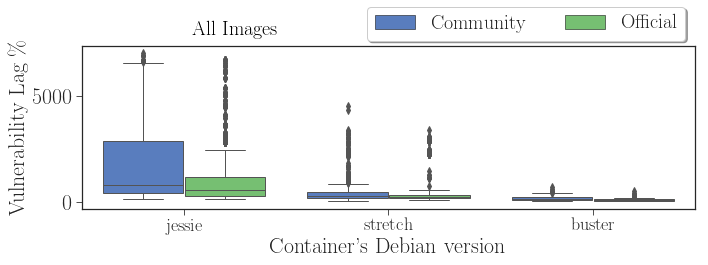

In [32]:
######### concatinating both dataframes : offical and community
if True:
    df_tmp=(lag_vul_all.
            groupby(['name','debian','type']).
            count().
            sort_values('source', ascending=False).
            reset_index()
           )

order=['jessie','stretch','buster']

ax = sns.boxplot(x="debian", y="source", data=df_tmp, hue="type", palette="muted", order=order, linewidth=1)
ax.figure.set_size_inches(11,3)
ax.set_xlabel("Container's Debian version")
ax.set_ylabel('Vulnerability Lag \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.18, 1.15, 'All Images', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')
#ax.set_ylim(0,3000)

Text(0,0.5,'Vulnerability lag')

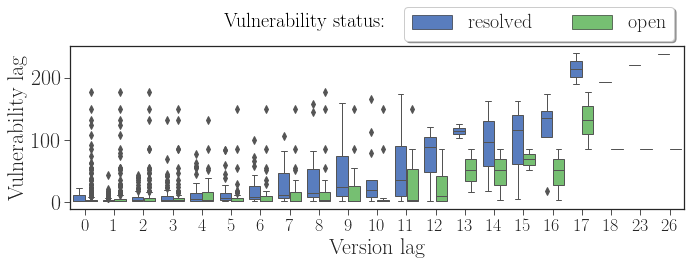

In [25]:
if True:
    df_tmp=(lag_vul_all.query('status=="resolved" or status=="open"').
            loc[:,['source','source_version','date_y','status','release_snapshot','outdate','cve']])
    df_tmp.drop_duplicates(inplace=True)
    df_tmp=df_tmp.groupby(['source','source_version','outdate','status','cve']).count().reset_index()
    df_tmp=df_tmp.groupby(['source','source_version','outdate','status']).count().reset_index()
    df_tmp.sort_values('outdate',ascending=False, inplace=True)
    df_tmp['outdate']=df_tmp['outdate'].apply(int)

ax = sns.boxplot(x="outdate", y="cve", hue="status", data=df_tmp,  palette="muted", linewidth=1)
ax.figure.set_size_inches(11,3)
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.25, 1.2, 'Vulnerability status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

ax.set_xlabel('Version lag')
ax.set_ylabel('Vulnerability lag')
#ax.set_ylim(0,80)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

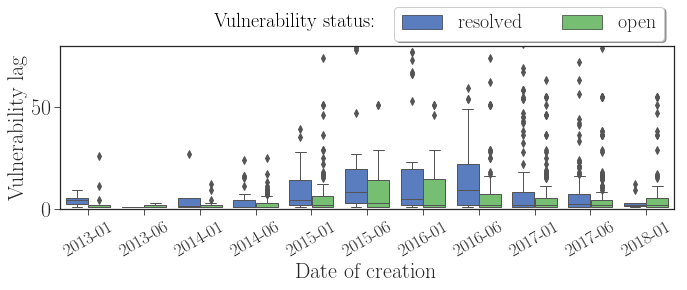

In [26]:
if True:
    df_tmp=lag_vul_all
    df_tmp['date']=df_tmp['date_y'].apply(lambda x: 
                                          x[0:4]+'-01' if str(int(x[4:6])/7)[0:1] == "0"
                                         else x[0:4]+'-06' )
    #df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.date(x, "%Y-%m"))
if True:
    df_tmp=(df_tmp.query('status=="resolved" or status=="open"').
            loc[:,['source','source_version','date','status','release_snapshot','outdate','cve']])
    df_tmp.drop_duplicates(inplace=True)
    df_tmp=df_tmp.groupby(['source','source_version','date','status','cve']).count().reset_index()
    df_tmp=df_tmp.groupby(['source','source_version','date','status']).count().reset_index()
    
df_tmp.sort_values('date', ascending=True, inplace=True)
ax = sns.boxplot(x="date", y="cve", hue="status", data=df_tmp,  palette="muted", linewidth=1)
ax.figure.set_size_inches(11,3)
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.25, 1.2, 'Vulnerability status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

ax.set_xlabel('Date of creation')
ax.set_ylabel('Vulnerability lag')
ax.set_ylim(0,80)
plt.xticks(rotation='30')



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

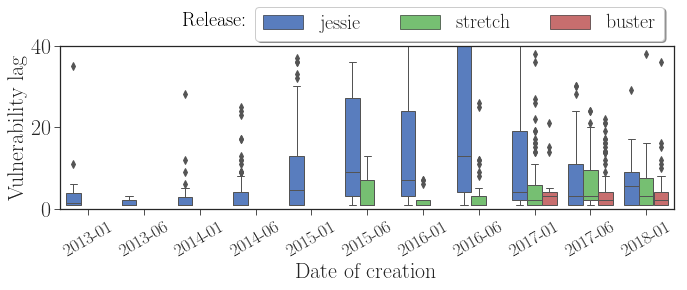

In [27]:
if True:
    df_tmp=lag_vul_all
    df_tmp['date']=df_tmp['date_y'].apply(lambda x: 
                                          x[0:4]+'-01' if str(int(x[4:6])/7)[0:1] == "0"
                                         else x[0:4]+'-06' )
    #df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.date(x, "%Y-%m"))
if True:
    df_tmp2=(df_tmp.query('status=="resolved" or status=="open"').
            loc[:,['source','source_version','date','status','release_snapshot','isOutdate','cve']])
    df_tmp2.drop_duplicates(inplace=True)
    df_tmp2=df_tmp2.groupby(['source','source_version','date','release_snapshot','cve']).count().reset_index()
    df_tmp2=df_tmp2.groupby(['source','source_version','date','release_snapshot']).count().reset_index()

df_tmp2.sort_values('date', ascending=True, inplace=True)
ax = sns.boxplot(x="date", y="cve", hue="release_snapshot", data=df_tmp2,  palette="muted", linewidth=1)
ax.figure.set_size_inches(11,3)
for patch in ax.patches:
    patch.set_edgecolor('black')

ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.2, 1.2, 'Release:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

ax.set_xlabel('Date of creation')
ax.set_ylabel('Vulnerability lag')
ax.set_ylim(0,40)
plt.xticks(rotation='30')

In [900]:
###### number of vulnerable source packages by year and release
df_all['year']=df_all['date'].apply(lambda x: x[0:4])
(df_all.query('outdate==0').
 groupby(['source','source_version','year','release_snapshot']).
 count().
 groupby(['release_snapshot','year']).
 count())

package  version  version_order  last_order  date  \
release_snapshot year                                                      
buster           2017       37       37             37          37    37   
                 2018       52       52             52          52    52   
jessie           2013        4        4              4           4     4   
                 2014       25       25             25          25    25   
                 2015       23       23             23          23    23   
                 2016       23       23             23          23    23   
                 2017       75       75             75          75    75   
                 2018       19       19             19          19    19   
stretch          2015        1        1              1           1     1   
                 2016       30       30             30          30    30   
                 2017      106      106            106         106   106   
                 2018       29       29             29          29    29   

                       outdate  isOutdate  urgency  status  cve  
release_snapshot year                                            
buster           2017       37         37       37      37   37  
                 2018       52         52       52      52   52  
jessie           2013        4          4        4       4    4  
                 2014       25         25       25      25   25  
                 2015       23         23       23      23   23  
                 2016       23         23       23      23   23  
                 2017       75         75       75      75   75  
                 2018       19         19       19      19   19  
stretch          2015        1          1        1       1    1  
                 2016       30         30       30      30   30  
                 2017      106        106      106     106  106  
                 2018       29         29       29      29   29

################################################################################################################
################################################################################################################
# Let's check Bugs 
If yoou don't want to analyze only bugs without knowing the type of container, you can skip this part
################################################################################################################
################################################################################################################

In [34]:
# Still need work on this, not finished yet
bugs=pd.read_csv('../docker/csv/docker_notProcessed_bugs.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
bugs['type']='normal'

archived_bugs=pd.read_csv('../docker/csv/docker_notProcessed_archived_bugs.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
archived_bugs['type']='archived'

packages_bugs=pd.concat([bugs,archived_bugs])
packages_bugs.drop_duplicates(inplace=True)
packages_bugs.fillna('undefined', inplace=True)

packages_bugs['source_version']=packages_bugs['found_in'].apply(lambda x:
                                                         str(x).split('/')[-1])

packages_bugs['fixed_in']=packages_bugs['fixed_in'].apply(lambda x:
                                                         str(x).split('/')[-1])
packages_bugs.drop_duplicates(inplace=True)
len(packages_bugs)

169786

In [35]:
packages_bugs.head()

,arrival,debianbug,fixed_in,found_in,last_modified,package,severity,status,type,source_version
0,2007-05-15 13:30:02,424037,undefined,abiword/2.4.6-1.1,2008-07-11 10:06:01,abiword,wishlist,forwarded,normal,2.4.6-1.1
1,2008-02-14 13:03:02,465741,undefined,abiword/2.4.6-5,2010-02-20 14:42:09,abiword,wishlist,pending,normal,2.4.6-5
2,2008-06-08 08:48:07,485090,undefined,abiword/2.4.6-5,2008-07-11 12:42:08,abiword,wishlist,forwarded,normal,2.4.6-5
3,2009-05-14 17:06:01,528679,undefined,abiword/2.6.8-5,2012-03-03 11:01:11,abiword,wishlist,forwarded,normal,2.6.8-5
4,2010-01-17 00:03:02,565561,undefined,abiword/2.8.1-2,2010-01-17 00:03:05,abiword,wishlist,pending,normal,2.8.1-2


In [36]:
# I merge on package and source_version, because the field "found_in" is refering to the source
df=(packages_bugs.
    set_index(['package','source_version']).
    merge(debian_packages.
          set_index(['package','source_version']),
          left_index=True, 
          right_index=True, 
          how='outer')
   ).reset_index().dropna()


In [786]:
### this is to get where bugs where fixed
#df_t=df.query('type=="normal" and status=="done"').groupby(['debianbug','found_in']).count().reset_index()
#df_t.loc[:,['debianbug','found_in']].to_csv('../docker/csv/remove_later_normal_bugs.csv', index=False, sep=';')

### and then run the script get_bug_fixed_in.py

In [37]:
# Merge the new informations with the old ( TWO DIFFERENT PROCESS)
normal_done=pd.read_csv('../docker/csv/docker_notProcessed_bugs_status_done.csv', sep=';', 
                        dtype=object, index_col=['debianbug','found_in'],  error_bad_lines=False) # the new data

df_normal_done=df.query('type=="normal" and status=="done"').drop(['fixed_in'],axis=1) ## only "done and normal"
df_normal_done['debianbug']=df_normal_done['debianbug'].apply(int) ## only done and normal
df_normal_done.set_index(['debianbug','found_in'], inplace=True) ## only done and normal

others=df.query('type!="normal" or status!="done"') ## the others

df_nd=(df_normal_done. ## get the information about where fixed for the "done and normal" bugs
    merge(normal_done,
          left_index=True, 
          right_index=True, 
          how='outer')
   ).fillna('undefined').reset_index()

all_bugs=pd.concat([others,df_nd]).drop_duplicates() # merge everything and remove duplicates
print('all bugs that may be affecting the used packages', len(all_bugs))

all bugs that may be affecting the used packages 36907


In [850]:
# Use only once: Skip
# Identify bugs
#######################################################################################################
######################## This part is to track packages dates and releases ###########################
df_p=debian_packages
df_p['release']=df_p['release'].apply(lambda x: x.split('-')[0])

df_packages=(df_p.
 sort_values('date', ascending=True).
 groupby(['source','source_version','release']). ## this is different from vulnerabilities..
 first().
 drop(['package','version'], axis=1)
 )

dict_date=df_packages.to_dict() ### dict of source version dates

df_packages_release=(df_p.
 sort_values('date', ascending=True).
 groupby(['source','source_version']). ## this is different from vulnerabilities..
 first().
 drop(['package','version','date'], axis=1)
 )

dict_release=df_packages_release.to_dict() # dict of packages and source versions releases
#######################################################################################################
#######################################################################################################

df=(uniq_packages. ######## We create a DF with packages and their sources versions found in Docker containers
    groupby(['source','source_version']).
    count().
    drop(['package','version'], axis=1).
    reset_index()) ######## only source versions and distinct.

f=open('../docker/csv/docker_bugs.csv','w')
f.write('type;debianbug;package;source_version;arrival;last_modified;status;severity;release\n')

for index, raw in enumerate(df.iterrows()): ######## we iterate over the sources (docker)
    source=raw[1]['source']
    source_version=raw[1]['source_version']
    release=dict_release['release'][(source, source_version)]
    #if index==200:
    #    break
    #print(index)
    
    df_tmp=all_bugs.query('source=="'+source+'"').query('release=="'+release+'"')
    for index2, raw2 in enumerate(df_tmp.iterrows()):
        status=raw2[1]['status']
        arrival=raw2[1]['arrival']
        debianbug=str(raw2[1]['debianbug'])
        date_found_in=raw2[1]['date']
        fixed_in=raw2[1]['fixed_in']
        found_in=raw2[1]['found_in']
        last_modified=raw2[1]['last_modified']
        severity=raw2[1]['severity']
        #source=raw2[1]['source']
        package=raw2[1]['package']
        type=raw2[1]['type']
        try:
            date_current=dict_date['date'][(source, source_version,release)]
        except:
            continue
        if status!="done":
            if date_current>=date_found_in:
                f.write(type+';'+debianbug+';'+source+';'+source_version+';'+arrival+';'+last_modified+';'+status+';'+severity+';'+release+'\n')
    
        else:
            try:
                date_fixed=dict_date['date'][(source, fixed_in,release)]
            except:
                continue
            if date_current>=date_found_in and date_current<=date_fixed:
                f.write(type+';'+debianbug+';'+source+';'+source_version+';'+arrival+';'+last_modified+';'+status+';'+severity+';'+release+'\n')
f.close()

################################################################################################################
################################################################################################################
# NOW WE CHECK BUGS WITH THE INSTALLED PACKAGES
################################################################################################################
################################################################################################################


In [209]:
# BUGS
docker_bugs=pd.read_csv('../docker/csv/docker_bugs.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
docker_bugs.drop_duplicates(inplace=True)
bug_order=['wishlist','minor','normal','important','serious','grave','critical']
# Something about venn diagram
len(docker_bugs)

20960

In [169]:
len(docker_vulnerabilities)

28349

In [216]:
## HERE I CHECK WHICH VULS ARE IN BUGS
debianbugs=(docker_vulnerabilities.
 query('debianbug!="defined"').
 groupby('debianbug').
 count().
 loc[:,[]])
debianbugs['security']="True"
df_test=(docker_bugs.
         set_index('debianbug').
         merge(debianbugs,
               left_index=True,
               right_index=True,
               how='outer').
         fillna('False').
         reset_index().
         drop_duplicates()
        )
docker_bugs=df_test.query('arrival!="False"')
#docker_bugs=df_test.query('security=="False"')
#docker_bugs.drop(['security'], axis=1, inplace=True)
print(len(docker_bugs.groupby('debianbug').count()))
print(len(df_test.query('security=="True"').groupby('debianbug').count()))
print(len(debianbugs))

11774
1398
1398


In [177]:
len(docker_vulnerabilities.query('debianbug!="undefined"').groupby('cve').count())

1830

Text(0.18,1.15,'Status:')

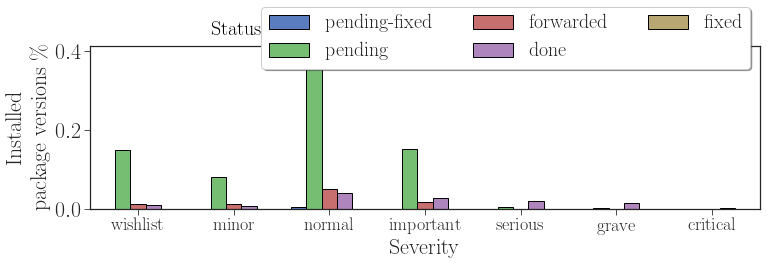

In [74]:

df_bug=docker_bugs.groupby(['severity','status']).count().reset_index()
df_bug['package']=df_bug['package']/len(docker_bugs)
df_bug=df_bug.sort_values('severity', ascending=False)

ax = sns.barplot(x="severity", 
                 y="package", 
                 hue="status", 
                 order=['wishlist','minor','normal','important','serious','grave','critical'],
                 data=df_bug, 
                 palette="muted", 
                 linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Severity")
ax.set_ylabel('Installed \n package versions \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.18, 1.15, 'Status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

In [214]:
len(docker_bugs)

20960

In [217]:
# Here we merge BUGS with community outdated packages
lag_bugs_community=(
    outdate_community.
    set_index(['package','source_version']).
    merge(df_test.
          set_index(['package','source_version']),
          left_index=True, 
          right_index=True, 
          how='outer').dropna().reset_index().drop_duplicates()
)
len(lag_bugs_community)

3342460

In [218]:
# Here we merge BUGS with official outdated packages
lag_bugs_official=(
    outdate_official.
    set_index(['package','source_version']).
    merge(docker_bugs.
          set_index(['package','source_version']),
          left_index=True, 
          right_index=True, 
          how='outer').dropna().reset_index().drop_duplicates()
)
len(lag_bugs_official)

1443313

In [219]:
# HERE I CONCAT BOTH
lag_bug_all=pd.concat([lag_bugs_official,lag_bugs_community])

(0, 1500)

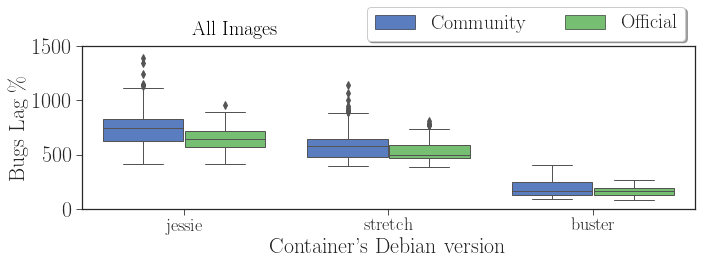

In [224]:
######### concatinating both dataframes : offical and community
if True:
    df_tmp=(lag_bug_all.query('security=="False"').
            groupby(['name','debian','type']).
            count().
            sort_values('package', ascending=False).
            reset_index()
           )

order=['jessie','stretch','buster']

ax = sns.boxplot(x="debian", y="package", data=df_tmp, hue="type", palette="muted", order=order, linewidth=1)
ax.figure.set_size_inches(11,3)
ax.set_xlabel("Container's Debian version")
ax.set_ylabel('Bugs Lag \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.18, 1.15, 'All Images', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')
ax.set_ylim(0,1500)

(0, 50)

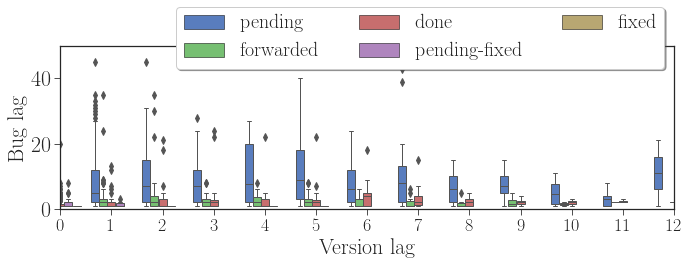

In [225]:
if True:
    df_tmp=(lag_bug_all.query('security=="False"').#query('status=="resolved" or status=="open"').
            loc[:,['package','source_version','date','status','release_snapshot','outdate','debianbug']])
    df_tmp.drop_duplicates(inplace=True)
    df_tmp=df_tmp.groupby(['package','source_version','outdate','status','debianbug']).count().reset_index()
    df_tmp=df_tmp.groupby(['package','source_version','outdate','status']).count().reset_index()
    df_tmp.sort_values('outdate',ascending=False, inplace=True)
    df_tmp['outdate']=df_tmp['outdate'].apply(int)

ax = sns.boxplot(x="outdate", y="debianbug", hue="status", data=df_tmp,  palette="muted", linewidth=1)
ax.figure.set_size_inches(11,3)
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.25, 1.2, 'Bug status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

ax.set_xlabel('Version lag')
ax.set_ylabel('Bug lag')
ax.set_xlim(0,12)
ax.set_ylim(0,50)



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

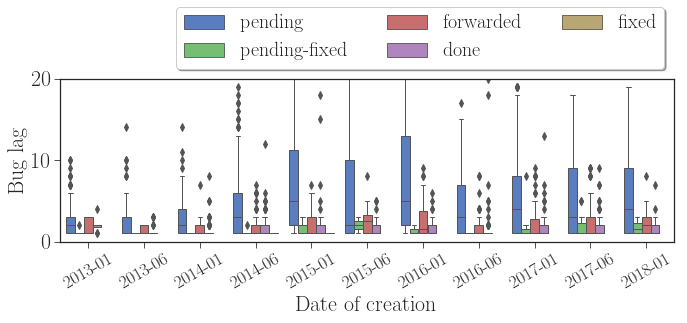

In [232]:
if True:
    df_tmp=lag_bug_all.query('security=="False"')
    df_tmp['date']=df_tmp['date'].apply(lambda x: 
                                          x[0:4]+'-01' if str(int(x[4:6])/7)[0:1] == "0"
                                         else x[0:4]+'-06' )
    #df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.date(x, "%Y-%m"))
if True:
    df_tmp=(df_tmp.
            loc[:,['package','source_version','date','status','release_snapshot','debianbug']])
    df_tmp.drop_duplicates(inplace=True)
    df_tmp=df_tmp.groupby(['package','source_version','date','status','debianbug']).count().reset_index()
    df_tmp=df_tmp.groupby(['package','source_version','date','status']).count().reset_index()
    
df_tmp.sort_values('date', ascending=True, inplace=True)
ax = sns.boxplot(x="date", y="debianbug", hue="status", data=df_tmp,  palette="muted", linewidth=1)
ax.figure.set_size_inches(11,3)
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.5), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.25, 1.2, 'Bug status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

ax.set_xlabel('Date of creation')
ax.set_ylabel('Bug lag')
ax.set_ylim(0,20)
plt.xticks(rotation='30')



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

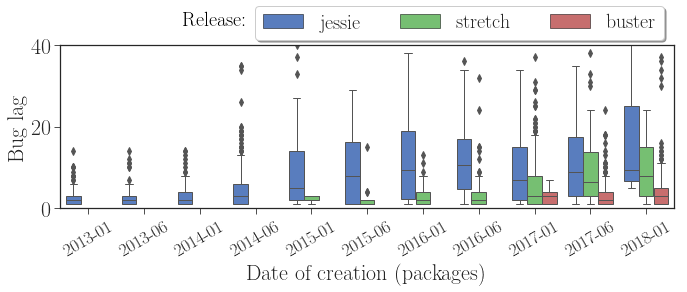

In [233]:
if True:
    df_tmp=lag_bug_all.query('security=="False"')
    df_tmp['date']=df_tmp['date'].apply(lambda x: 
                                          x[0:4]+'-01' if str(int(x[4:6])/7)[0:1] == "0"
                                         else x[0:4]+'-06' )
    #df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.date(x, "%Y-%m"))
if True:
    df_tmp2=(df_tmp.#query('status=="resolved" or status=="open"').
            loc[:,['package','source_version','date','release_snapshot','debianbug']])
    df_tmp2.drop_duplicates(inplace=True)
    df_tmp2=df_tmp2.groupby(['package','source_version','date','release_snapshot','debianbug']).count().reset_index()
    df_tmp2=df_tmp2.groupby(['package','source_version','date','release_snapshot']).count().reset_index()

df_tmp2.sort_values('date', ascending=True, inplace=True)
ax = sns.boxplot(x="date", y="debianbug", hue="release_snapshot", data=df_tmp2,  palette="muted", linewidth=1)
ax.figure.set_size_inches(11,3)
for patch in ax.patches:
    patch.set_edgecolor('black')

ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.2, 1.2, 'Release:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

ax.set_xlabel('Date of creation (packages)')
ax.set_ylabel('Bug lag')
ax.set_ylim(0,40)
plt.xticks(rotation='30')

In [289]:
df_tmp2=(lag_bugs_official.
         groupby(['package','name','debian']).
         count().
         reset_index().
         set_index('package').
         loc[:,['debianbug','debian']].
         merge(lag_bugs_official.
             groupby(['package','name']).
             count().
             reset_index().
             groupby(['package']).
             count().
             loc[:,['version']],
             left_index=True, 
             right_index=True, 
             how='outer').dropna().reset_index()
        )
df_tmp2['version']=(df_tmp2['version']/100).apply(int)

(0, 80)

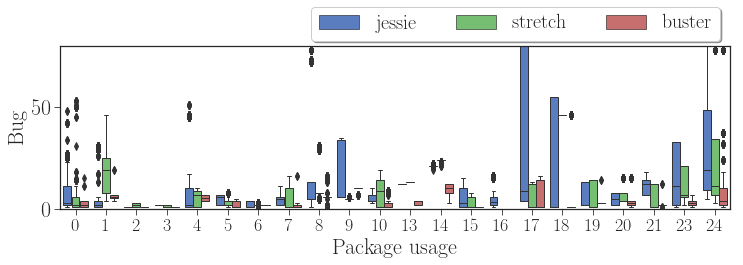

In [290]:
##### USAGE OR POPULARITY


#df_tmp2=df_tmp2.query('status!="fixed" and status!="pending-fixed"')# and status!="forwarded"')
ax = sns.boxplot(x="version", y="debianbug", data=df_tmp2, hue='debian',  palette="muted", linewidth=1)
ax.figure.set_size_inches(11,3)
for patch in ax.patches:
    patch.set_edgecolor('black')
for x in ax.artists:
    x.set_edgecolor('.2')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)

plt.setp(ax.lines, color=".2", mfc='.2', mec='.2')

ax.figure.set_size_inches(12,3)

ax.set_ylabel('Bug')
ax.set_xlabel('Package usage')
ax.set_ylim(0,80)